# Iterative Closest Point (ICP)

In [1]:
# imports
import numpy as np
import numpy.linalg
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

from typing import Tuple, List

## Implementation

In [2]:
import icp.icp as other_icp # Import OK

## Data setup

### Rigid transformation

Let $M$ be a rigid transformation matrix. To transform a single point $P$ with $M$ as the rigid transformation such as $P^{'}$ is position of the transformed point, we have $P^{'} = PM$ with $P, M \text{ and } P^{'}$ expressed in **homogeneous coordinates**

#### 2D rigid transformation

2D Translation & Rotation matrix:
$$
M =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & t_x \\
\sin(\theta) & \cos(\theta) & t_y \\
0 & 0 & 1 \\
\end{bmatrix}
$$

In [3]:
def randomTransformation2D(maxRot: float = 30, maxTrans: float = 1):
    """
    Generate random 2D rigid transformation centered at the origin and with
    an angle in [-maxRot; maxRot] and a translation in lower than maxTrans

    Parameters
    ----------
    maxRot : float
        maximum rotation in degrees
    maxTrans : float
        maximum norm for the translation vector

    Returns
    -------
    M : np.array
        Generated random 2d rigid transformation
    """

    M = np.zeros((3, 3), dtype=float)

    # Angle
    angle = np.random.uniform(-maxRot, maxRot)
    # Convert degrees to radian
    angle = angle * np.pi / 180
    M[0:2, 0:2] = np.array([[np.cos(angle), -np.sin(angle)],
                              [np.sin(angle), np.cos(angle)]])

    # Translation
    translation = np.random.uniform(-maxTrans / np.sqrt(2), maxTrans / np.sqrt(2), size=2)
    assert np.linalg.norm(translation) <= maxTrans
    M[0:2, 2] = translation
    M[2, 2] = 1

    return M

randomTransformation2D()

array([[ 0.98935252, -0.14553896, -0.09936415],
       [ 0.14553896,  0.98935252, -0.0873654 ],
       [ 0.        ,  0.        ,  1.        ]])

#### 3D rigid transformation


3D rotation matrix:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a6821937d5031de282a190f75312353c970aa2df)

Therefore, the **3D translation & rotation matrix** looks like:

If rotation on `z axis`
$$
M =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 & t_x\\
\sin(\theta) & \cos(\theta) & 0 & t_y\\
0 & 0 & 1 & t_z\\
0 & 0 & 0 & 1
\end{bmatrix}
$$

In [4]:
def randomTransformation3D(maxRot: float = 30, maxTrans: float = 1):
    """
    Generate random 3D rigid transformation centered at the origin and with
    an angle in [-maxRot; maxRot] and a translation in lower than maxTrans

    Parameters
    ----------
    maxRot : float
        maximum rotation in degrees
    maxTrans : float
        maximum norm for the translation vector

    Returns
    -------
    M : np.array
        Generated random 2d rigid transformation
    """

    M = np.zeros((4, 4), dtype=float)

    # Angle
    angle = np.random.uniform(-maxRot, maxRot)
    # Convert degrees to radian
    angle = angle * np.pi / 180

    # FIXME: random axis rotation
    M[0:3, 0:3] = np.array([[np.cos(angle), -np.sin(angle), 0],
                            [np.sin(angle), np.cos(angle), 0],
                            [0, 0, 1]])

    # Translation
    translation = np.random.uniform(-maxTrans / np.sqrt(3), maxTrans / np.sqrt(3), size=3)
    assert np.linalg.norm(translation) <= maxTrans
    M[0:3, -1] = translation
    M[-1, -1] = 1

    return M

randomTransformation3D()

array([[ 0.94963917,  0.31334557,  0.        ,  0.54610407],
       [-0.31334557,  0.94963917,  0.        ,  0.18460291],
       [ 0.        ,  0.        ,  1.        , -0.09489101],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### Generate data

#### Uniforme 2D square

In [5]:
def generate_uniform_2d_square(width:float, nb_points_edge:int) -> np.array:
    """
    Generate uniform 2D square with homogeneous points on the edges

    Parameters
    ----------
    width : float
        Size of the square
    nb_points_edge:
        Number of points on each edge

    Returns
    -------
    square_2d : np.array
        Generated uniform 2D square with shape (nb_points_edge * 4, 3)
    """

    edge_points = np.linspace(-width/2, width/2, nb_points_edge)
    # top: x axis different, y = width / 2
    edges_points_2d = np.expand_dims(edge_points, axis=-1)
    top = np.concatenate((edges_points_2d, np.full((len(edge_points), 1), width / 2)), axis=-1)
    # bottom: x axis different, y = -width / 2
    bottom = np.concatenate((edges_points_2d, np.full((len(edge_points), 1), -width / 2)), axis=-1)
    # left: x = -width / 2, y axis different
    left = np.concatenate((np.full((len(edge_points), 1), -width / 2), edges_points_2d), axis=-1)
    # right: x = width / 2, y axis different
    right = np.concatenate((np.full((len(edge_points), 1), width / 2), edges_points_2d), axis=-1)
    # Stack all the points
    points = np.vstack((top, bottom, left, right))
    # Homogenous points
    points = np.concatenate((points, np.ones((len(points), 1))), axis=-1)
    return points


In [6]:
square_width = 1
square_2d = generate_uniform_2d_square(width=square_width, nb_points_edge=10)
square_2d.shape, square_2d.dtype

((40, 3), dtype('float64'))

Text(0.5, 1.0, '2D Square')

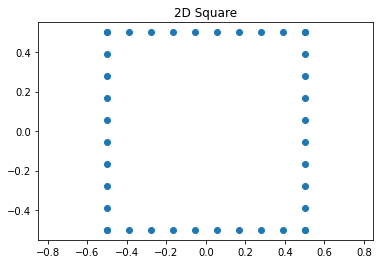

In [7]:
plt.scatter(square_2d[:, 0], square_2d[:, 1])
plt.axis('equal')
plt.title("2D Square")

In [8]:
M_uniform_square = randomTransformation2D(maxRot=20, maxTrans=1)
print("Rotation & translation matrix: ", M_uniform_square.shape), print(M_uniform_square),
print("Square 2D shape: ", square_2d.shape)
# Rotate and translate basic square
square_2d_transformed = square_2d @ M_uniform_square.T # FIXME: what it does not work with no transpose...

Rotation & translation matrix:  (3, 3)
[[ 0.94661854  0.32235592 -0.20085763]
 [-0.32235592  0.94661854  0.35469041]
 [ 0.          0.          1.        ]]
Square 2D shape:  (40, 3)


Text(0.5, 1.0, '2D Square with rotation')

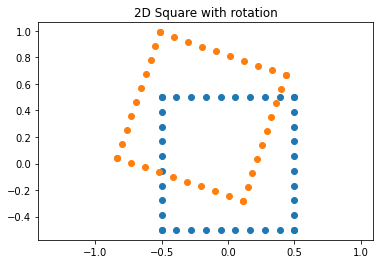

In [9]:
plt.scatter(square_2d[:, 0], square_2d[:, 1])
plt.scatter(square_2d_transformed[:, 0], square_2d_transformed[:, 1])
plt.axis('equal')
plt.title("2D Square with rotation")

#### Non uniform 2D square

In [10]:
def generate_random_2d_square(width, min_side_points=10, max_side_points=20):
    """
    Generate random 2D square with homogeneous points on the edges

    Parameters
    ----------
    width : float
        Size of the square
    min_edge_points:
        Minimum number of points on each edge
    max_edge_points:
        Maximum number of points on each edge

    Returns
    -------
    square_2d : np.array
        Generated random 2D square with shape (M, 3)
        with M in [4 * min_side_points, 4 * max_side_points]
    """
    # Similar to generate_uniform_2d_square
    # Returns number of points for the 4 sides
    nb_edge_points = np.random.randint(min_side_points, max_side_points, 4)

    # Compute random number between [0, 1], multiply by the width to distribute over the width
    # And substract width / 2 to center the points
    points = np.random.random_sample(nb_edge_points[0]) * width - width / 2
    top = np.concatenate((np.expand_dims(points, axis=-1), np.full((len(points), 1), width / 2)), axis=1)

    points = np.random.random_sample(nb_edge_points[1]) * width - width / 2
    bottom = np.concatenate((np.expand_dims(points, axis=-1), np.full((len(points), 1), -width / 2)), axis=1)

    points = np.random.random_sample(nb_edge_points[2]) * width - width / 2
    left = np.concatenate((np.full((len(points), 1), -width / 2), np.expand_dims(points, axis=-1)), axis=1)

    points = np.random.random_sample(nb_edge_points[3]) * width - width / 2
    right = np.concatenate((np.full((len(points), 1), width / 2), np.expand_dims(points, axis=-1)), axis=1)

    points = np.concatenate((top, bottom, left, right), axis=0)
    points = np.concatenate((points, np.ones((len(points), 1))), axis=-1)
    return points

In [11]:
random_square_2d = generate_random_2d_square(width=1)
# /!\ Not the same number of points
random_square_2d_transformed = generate_random_2d_square(width=1)
M_random_square = randomTransformation2D(maxRot=25)
random_square_2d_transformed = random_square_2d_transformed @ M_random_square.T

Text(0.5, 1.0, 'Random 2D Squares')

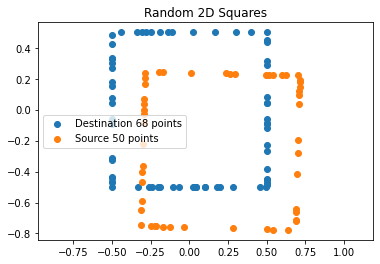

In [12]:
plt.scatter(random_square_2d[:, 0], random_square_2d[:, 1],
            label=f"Destination {len(random_square_2d)} points")
plt.scatter(random_square_2d_transformed[:, 0], random_square_2d_transformed[:, 1],
            label=f"Source {len(random_square_2d_transformed)} points")
plt.axis('equal')
plt.legend(loc='best')
plt.title("Random 2D Squares")

#### Non uniform 3D cube

In [13]:
def generate_3d_cube(width:float, min_face_points: int=500, max_face_points: int=750, missing_faces:List[Tuple[int, int]]=[]) -> np.array:
    """
    Generate 3D cube with homogeneous points

    Parameters
    ----------
    width : float
        Size of the square
    min_face_points: int
        Minimum number of points on each face
    max_face_points: int
        Maximum number of points on each face
    missing_faces: List[Tuple[int, int]]
        List of faces not to generate.
        Tuple[0] == axis [0, 1 or 2]
        Tuple[1] == id_face [0 or 1]
    Returns
    -------
    cube_3d : np.array
        Generated 3D cube with shape (M, 4)
        with M in [3 (axis) * 2 (nb_face_per_axis) * min_face_points,
                   3 (axis) * 2 (nb_face_per_axis) * max_face_points]
        if no missing faces
    """

    def generate_random_face_points(width, min_face_points, max_face_points):
        nb_points_face = np.random.randint(min_face_points, max_face_points, 1)[0]

        x_points = np.random.random_sample(nb_points_face) * width - width / 2
        y_points = np.random.random_sample(nb_points_face) * width - width / 2

        return np.concatenate((np.expand_dims(x_points, axis=-1), np.expand_dims(y_points, axis=-1)), axis=1)

    def check_generation(missing_faces: List[Tuple[int, int]], axis, face_id):
        for missing_face in missing_faces:
            if missing_face[0] == axis and missing_face[1] == face_id:
                return False
        return True

    # There are 3 axis
    # 2 faces for each axis
    faces = []
    for axis in range(3):
        if check_generation(missing_faces, axis, 0):
            face = generate_random_face_points(width, min_face_points, max_face_points)
            # On a face, there are 3 coordinates
            # 2 coordinates are generated randomly
            # 3rd coordinates is constant and equals +- width / 2
            faces.append(np.insert(face, axis, np.full(face.shape[0], -width / 2), axis=1))

        if check_generation(missing_faces, axis, 1):
            face = generate_random_face_points(width, min_face_points, max_face_points)
            faces.append(np.insert(face, axis, np.full(face.shape[0], width / 2), axis=1))

    points = np.concatenate(faces, axis=0)
    points = np.concatenate((points, np.ones((len(points), 1))), axis=-1)
    return points

In [14]:
random_cube_3d = generate_3d_cube(width=1)
random_cube_3d_transformed = generate_3d_cube(width=1)
M_random_cube = randomTransformation3D(maxRot=25)
random_cube_3d_transformed = random_cube_3d_transformed @ M_random_cube.T
random_cube_3d.shape, random_cube_3d_transformed.shape

((3747, 4), (3672, 4))

In [15]:
# Width matplotlib (no interaction)
# ax = fig.add_subplot(1, 1, 1, projection="3d")
# ax.scatter(, random_cube_3d[:, 1], random_cube_3d[:, 2])
# ax.scatter(random_cube_3d_transformed[:, 0], random_cube_3d_transformed[:, 1], random_cube_3d_transformed[:, 2])
def plot_cubes(source, destination):
    # Configure the trace.
    trace_source = go.Scatter3d(
        x=source[:, 0],
        y=source[:, 1],
        z=source[:, 2],
        mode='markers',
        marker={
            'size': 2,
        },
        name="source"
    )
    trace_destination = go.Scatter3d(
        x=destination[:, 0],
        y=destination[:, 1],
        z=destination[:, 2],
        mode='markers',
        marker={
            'size': 2,
        },
        name="destination"
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )

    data = [trace_destination, trace_source]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)

In [16]:
plot_cubes(random_cube_3d_transformed, random_cube_3d)
# If the cell is empty rerun the notebook. There should be a 3D interactive plot.

## Test

In this section:
* The ICP is going to be applied on different data (2D or 3D)
* One subsection for each data
* Visualize each step of the ICP
* Compute metrics about ICP efficiency (MSE)

### Uniform 2D square

Apply `nearest_neighbor` function over the two squared and visualize the square

In [17]:
distances, indices_dst = other_icp.nearest_neighbor(square_2d_transformed, square_2d)
indices_dst

array([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  8, 25, 25, 24, 24, 24, 23, 23,
       14, 15, 16, 25, 26, 27, 28,  0,  0,  0,  0,  0,  0, 16, 16, 34, 35,
       36, 37,  7,  8,  8,  8])

In [18]:
square_2d_transformed.shape

(40, 3)

In [19]:
def plot_pairing(source: np.ndarray,
                 destination: np.ndarray,
                 ax=None,
                 title: str=None) -> None:
    """
    Plot pairing from the source points to the destination point.
    Destination points are in blue
    Source points are in orange

    Parameters
    ----------
    source : np.ndarray
        Source points clouds (N, dim)
        N: number of points
        dim: homogeneous coordinates (2D: 3, 3D: 4)
    destination: np.ndarray
        Destination points clouds (N, dim)
        N: number of points
        dim: homogeneous coordinates (2D: 3, 3D: 4)
    ax: matplotlib.axes.Axes, optional
        axes used to plot. If not given, use classic `plt` methods.
    title: str, optional
        title for the plot
    """
    title_func = plt.title
    if ax is None:
        if source.shape[-1] == 4: # 3D
            ax = plt.axes(projection="3d")
        else: # 2D
            ax = plt
    else:
        title_func = ax.set_title

    _, indices_dst = other_icp.nearest_neighbor(source, destination)

    if destination.shape[-1] == 3: # Homogeneous coordinates
        ax.scatter(destination[:, 0], destination[:, 1])
        ax.scatter(source[:, 0], source[:, 1])
        ax.plot(np.vstack((destination[indices_dst][:, 0], source[:, 0])),
                np.vstack((destination[indices_dst][:, 1], source[:, 1])), color='green')
        ax.axis('equal')
    elif destination.shape[-1] == 4:
        ax.scatter3D(destination[:, 0], destination[:, 1], destination[:, 2])
        ax.scatter3D(source[:, 0], source[:, 1], source[:, 2])
        ax.plot(np.concatenate((destination[indices_dst][:, 0], source[:, 0])),
                np.concatenate((destination[indices_dst][:, 1], source[:, 1])),
                np.concatenate((destination[indices_dst][:, 2], source[:, 2])), color='green')
    else:
        raise ValueError(f"Handle only 3D or 2D points. Got {destination.shape[-1] - 1}D")

    if title:
        title_func(title)

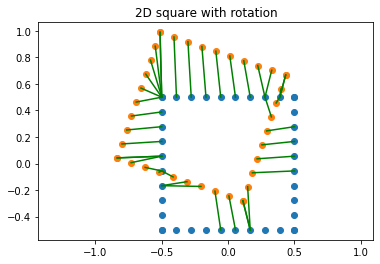

In [20]:
plot_pairing(square_2d_transformed, square_2d, title="2D square with rotation")

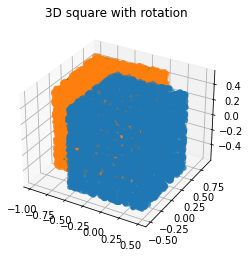

In [21]:
plot_pairing(random_cube_3d_transformed, random_cube_3d, title="3D square with rotation")

**Comments**:
* Some of the source points are paired to the same destination points (i.e left 3 source (orange) points are paired to 1 destination (blue) points)
* All the source points have at least/at most one destination pair.

In [22]:
# the function expects non homogeneous coordinates
T, distances, nb_iteration = other_icp.icp(square_2d_transformed[:, :-1], square_2d[:, :-1], M_uniform_square, max_iterations=20)
print(T.shape, distances.shape, nb_iteration)
print((square_2d_transformed @ T.T).shape)

(3, 3) (40,) 15
(40, 3)


In [23]:
def plot_distance_error(distances: np.ndarray,
                        title: str=None,
                        ax=None) -> None:
    """
    Plot pairing from the source points to the destination point

    Parameters
    ----------
    distances : np.ndarray
        distances of pairing points (array of distance from a source
        points to a destination point) (N)
        N: Number of source points
    title: str, optional
        title for the plot
    ax: matplotlib.axes.Axes, optional
        axes used to plot. If not given, use classic `plt` methods.
    """
    title_func = plt.title
    if ax is None:
        ax = plt
    else:
        title_func = ax.set_title

    ax.scatter(range(len(distances)), distances)
    ax.stem(range(len(distances)), distances, linefmt='r')

    mean_distances = np.mean(distances)
    ax.plot(np.full(len(distances), mean_distances), linestyle="dotted", color='orange') # Mean
    ax.set_ylim(0, 1)
    ax.text(len(distances) - 0.5 * len(distances), 0.8, "mean: {:.2f}".format(mean_distances))
    if title is not None:
        title_func(title)

In [24]:
def plot_icp_progress(source: np.ndarray,
                      destination: np.ndarray,
                      init_M: np.ndarray=None,
                      max_iterations: int=10,
                      icp_implem=other_icp) -> None:
    """
    Plot each ICP iteration's result with:
    -> visual current transformation
    -> pairing errors (distance error)
    -> MSE over time

    Parameters
    ----------
    source : np.ndarray
        Source points clouds (N, dim)
        N: number of points
        dim: homogeneous coordinates (2D: 3, 3D: 4)
    destination: np.ndarray
        Destination points clouds (N, dim)
        N: number of points
        dim: homogeneous coordinates (2D: 3, 3D: 4)
    max_iterations: int
        Number of maximum iteration (steps) for the ICP
        and maximum number of plots.
    icp_implem:
        ICP implementation module
    """
    
    assert source.ndim == destination.ndim
    assert source.shape[-1] == destination.shape[-1]

    fig = plt.figure(figsize = (20, 30))
    projection = "rectilinear" if source.shape[-1] == 3 else "3d"
    source_cpy = source.copy()

    errors = []

    for iter in range(1, max_iterations):
        T, distances, nb_iteration = icp_implem.icp(source_cpy[:, :-1], destination[:, :-1], init_M, max_iterations=iter, tolerance=0.00001)
        source_cpy = source_cpy @ T.T
        errors.append(np.mean(distances))
        ax = fig.add_subplot(max_iterations-1, 2, (iter-1) * 2 + 1, projection=projection)
        plot_pairing(source_cpy, destination, ax=ax)
        ax = fig.add_subplot(max_iterations-1, 2, (iter-1) * 2 + 2) # 2D in any cases
        plot_distance_error(distances, title=f"Pairing errors after {nb_iteration} iteration", ax=ax)

    fig, ax = plt.subplots(1, figsize=(15, 5))
    ax.set_title("Errors over iterations")
    ax.plot(range(1, len(errors)+1), errors)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Mean distances error")
    ax.set_xlim(1, len(errors))
    plt.show()

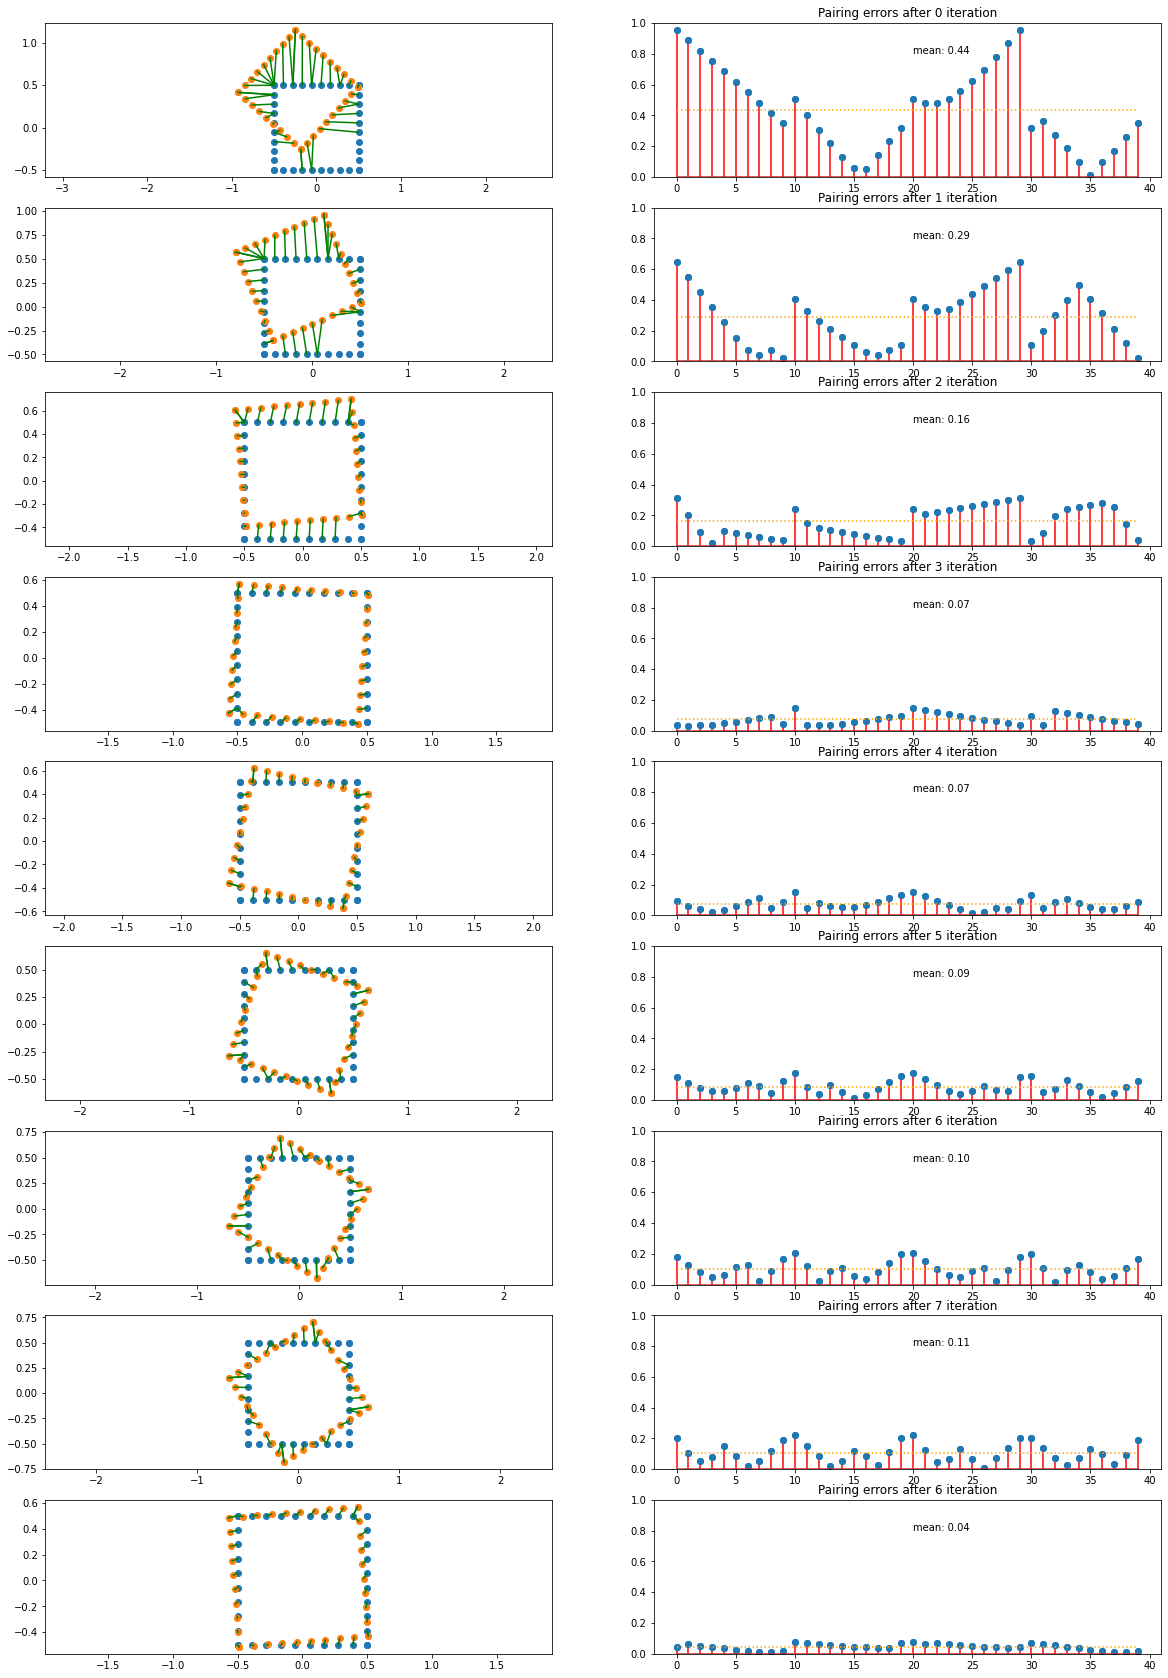

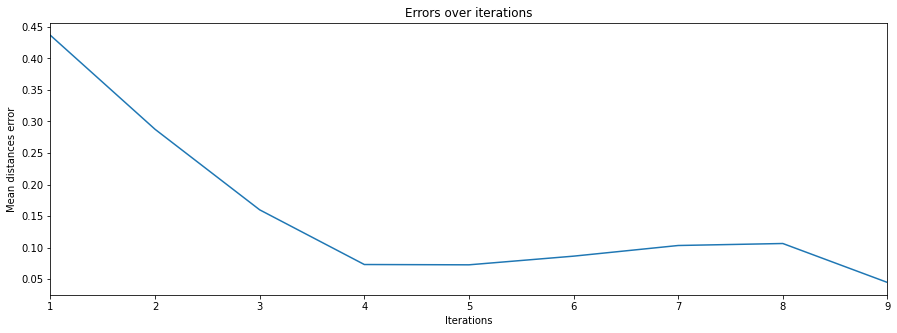

In [25]:
plot_icp_progress(square_2d_transformed, square_2d, M_uniform_square, max_iterations=10)

**Comments**:
* The ICP converge to the solution after 6 iterations
* But it seems it stops before the registration is totally correct even with a very low tolerance
* Output: not fully registred

### Random 2D square

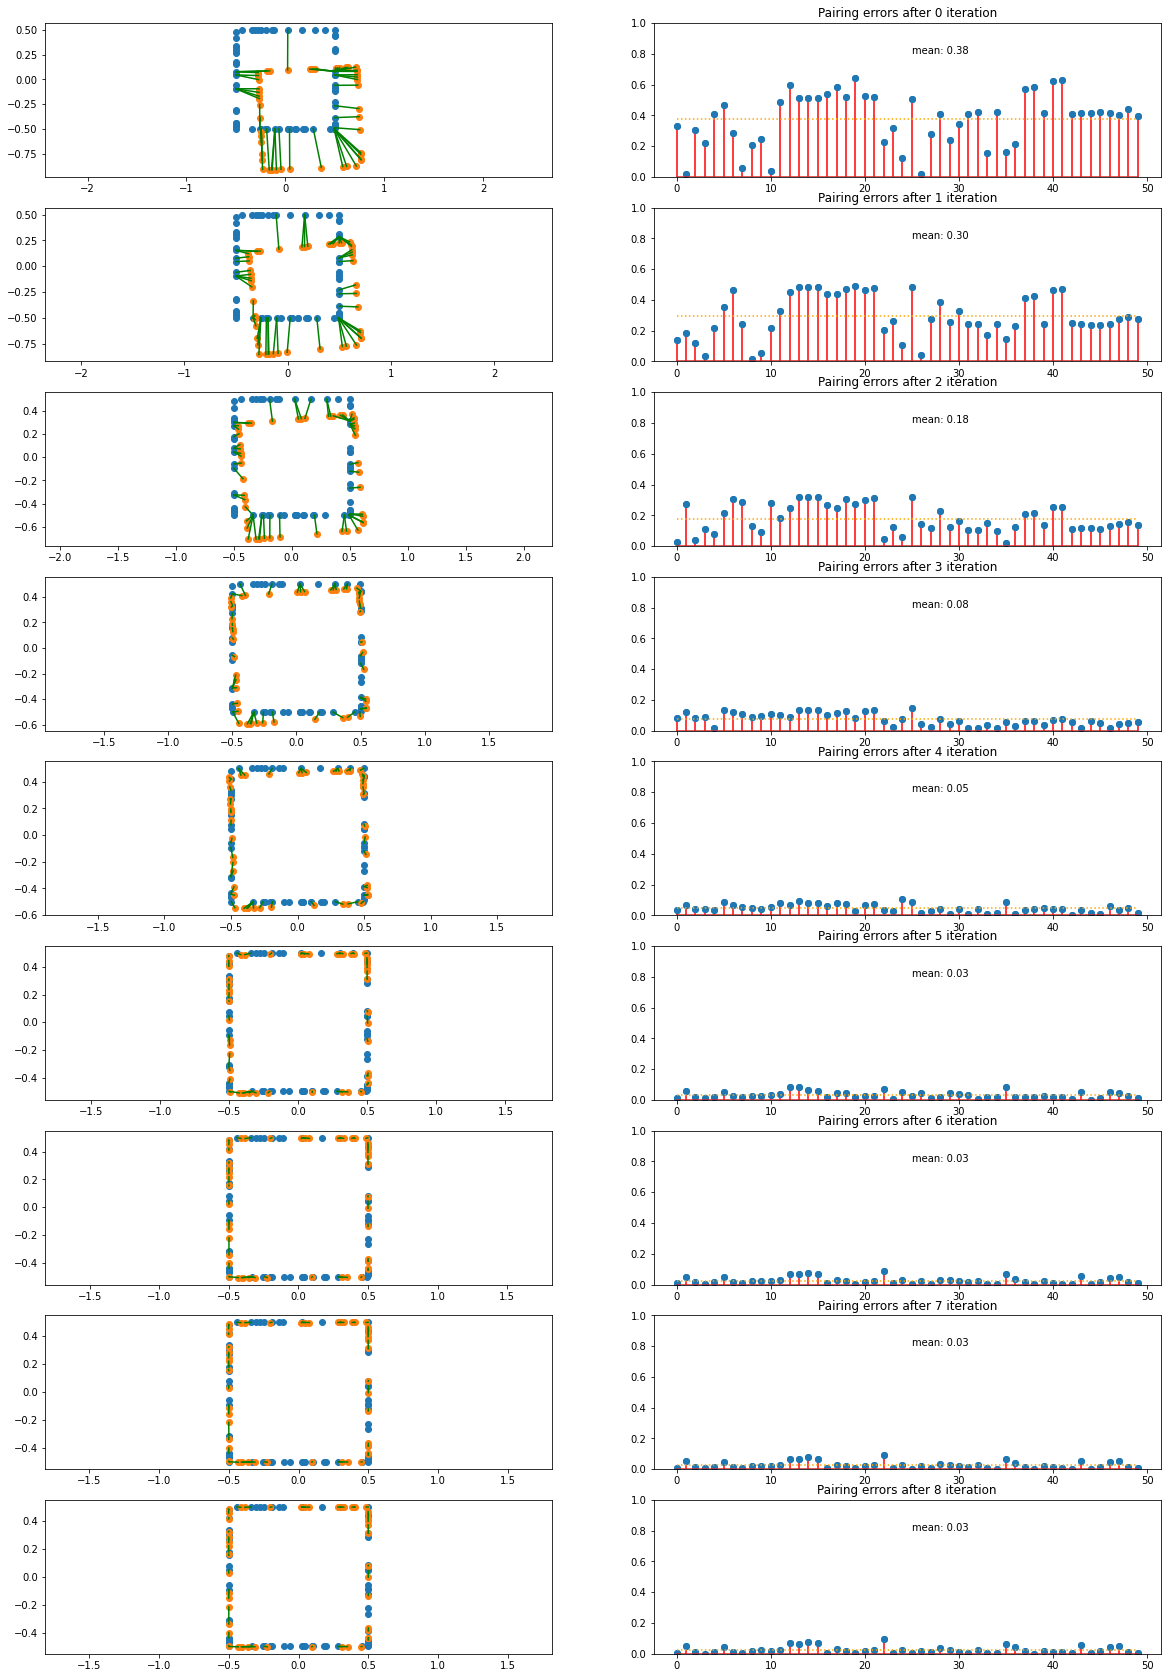

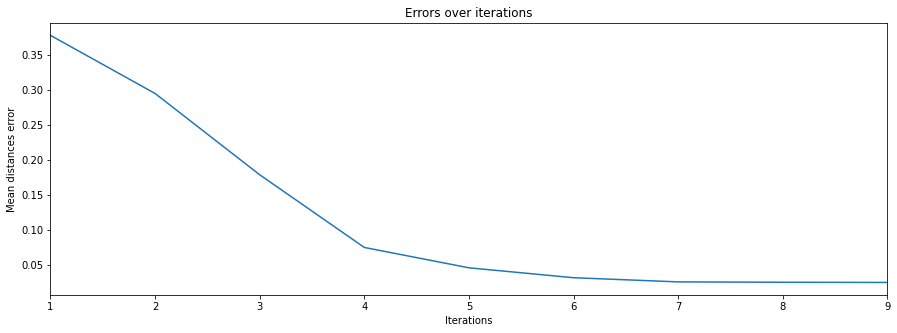

In [26]:
plot_icp_progress(random_square_2d_transformed, random_square_2d, M_random_square, max_iterations=10)

**Comments**:
* Same comments as with the uniform 2D square

### Random 3D cube

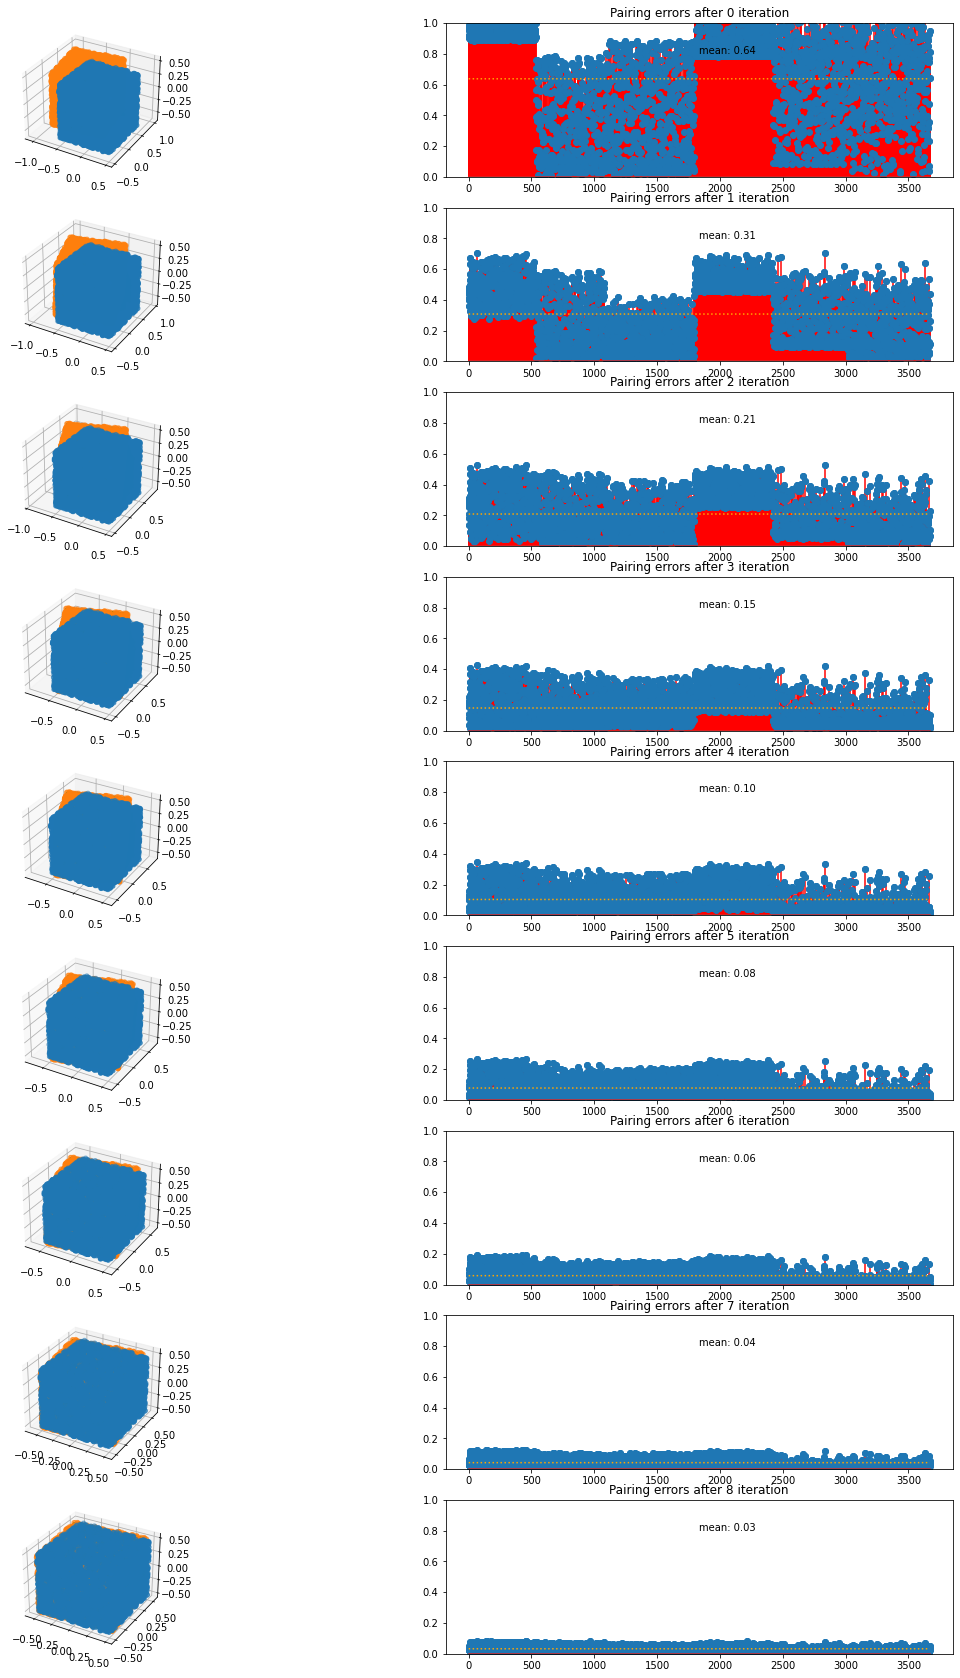

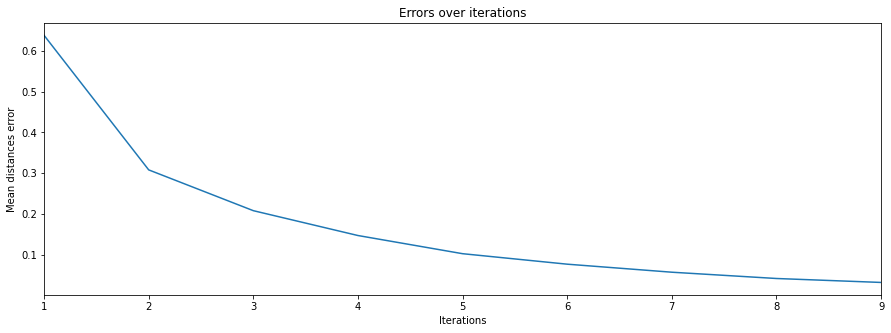

In [27]:
plot_icp_progress(random_cube_3d_transformed, random_cube_3d, M_random_cube)

**Comments**:
* The pairing errors gets lower with higher iteration
* Visually, the 3D source cube is almost registred with the 3D destination cube
* low MSE of 0.05 at the 8th iteration

**Conclusion**:
* The ICP works as well in 2D or 3D.
* The ICP works well even if the source points are not totally consistent with the destination data. 

## Variants

Let's test the ICP when many points are missing (i.e a face of a cube). We want to test the robustness of the ICP with inconsistent source points comparing to the expected destination points. 


### Missing face

Generate a cube with a missing face ($C_1$) and another regular cube ($C_2$). Apply a random transformation over $C_2$


### One face missing

In [28]:
C1 = generate_3d_cube(width=1, missing_faces=[(1, 1)]) # Front face missing
C2 = generate_3d_cube(width=1)
M_random_cube = randomTransformation3D(maxRot=25)
C2 = C2 @ M_random_cube.T
C1.shape, C2.shape

((2823, 4), (3715, 4))

In [29]:
# If the cell is empty rerun the notebook. There should be a 3D interactive plot.

plot_cubes(C2, C1)
# The missing face cannot really been seen in the plot at first.
# Try to move around the plot to find it.
# The front face should be missing
# The missing face is in the blue cube

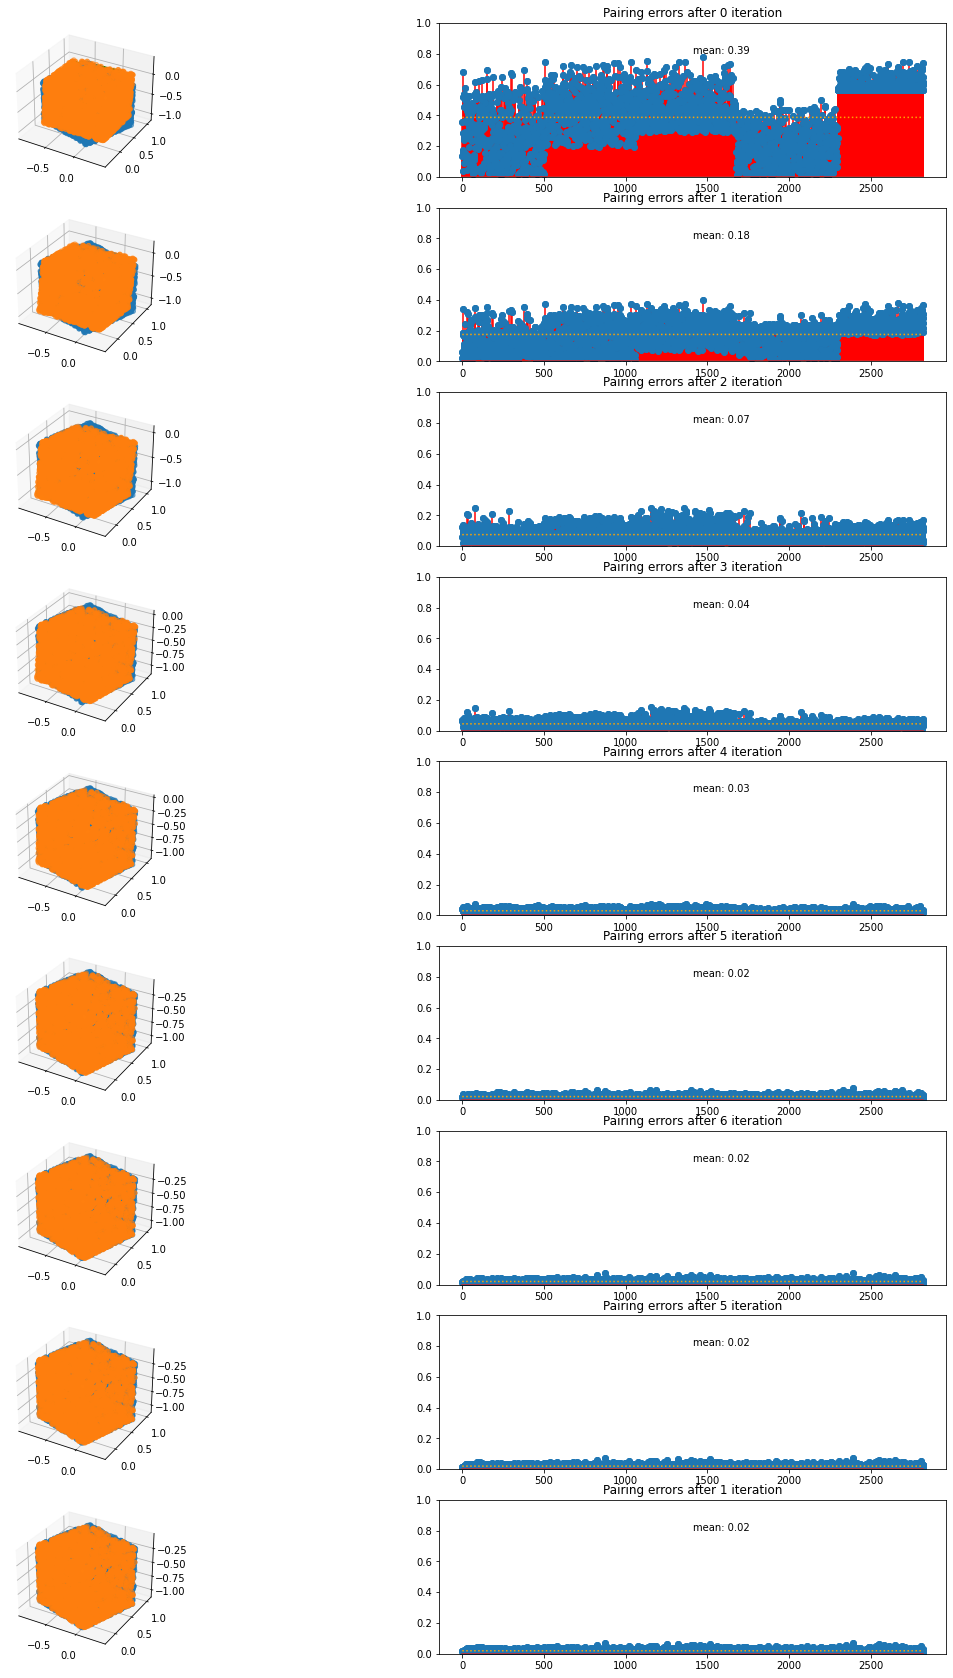

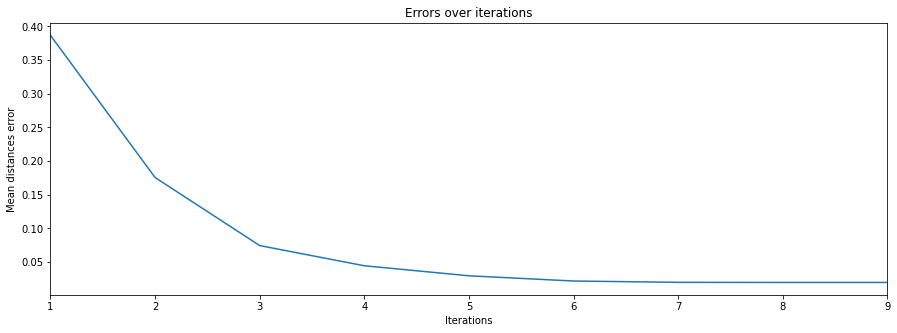

In [30]:
# C1: source
# C2: destination
# One face missing in the source cube
plot_icp_progress(C1, C2)

**Comments**:
* Even if there is one face missing in the source points, the registration works very well for all the points
* All the source points could find a close pair in the destination points.

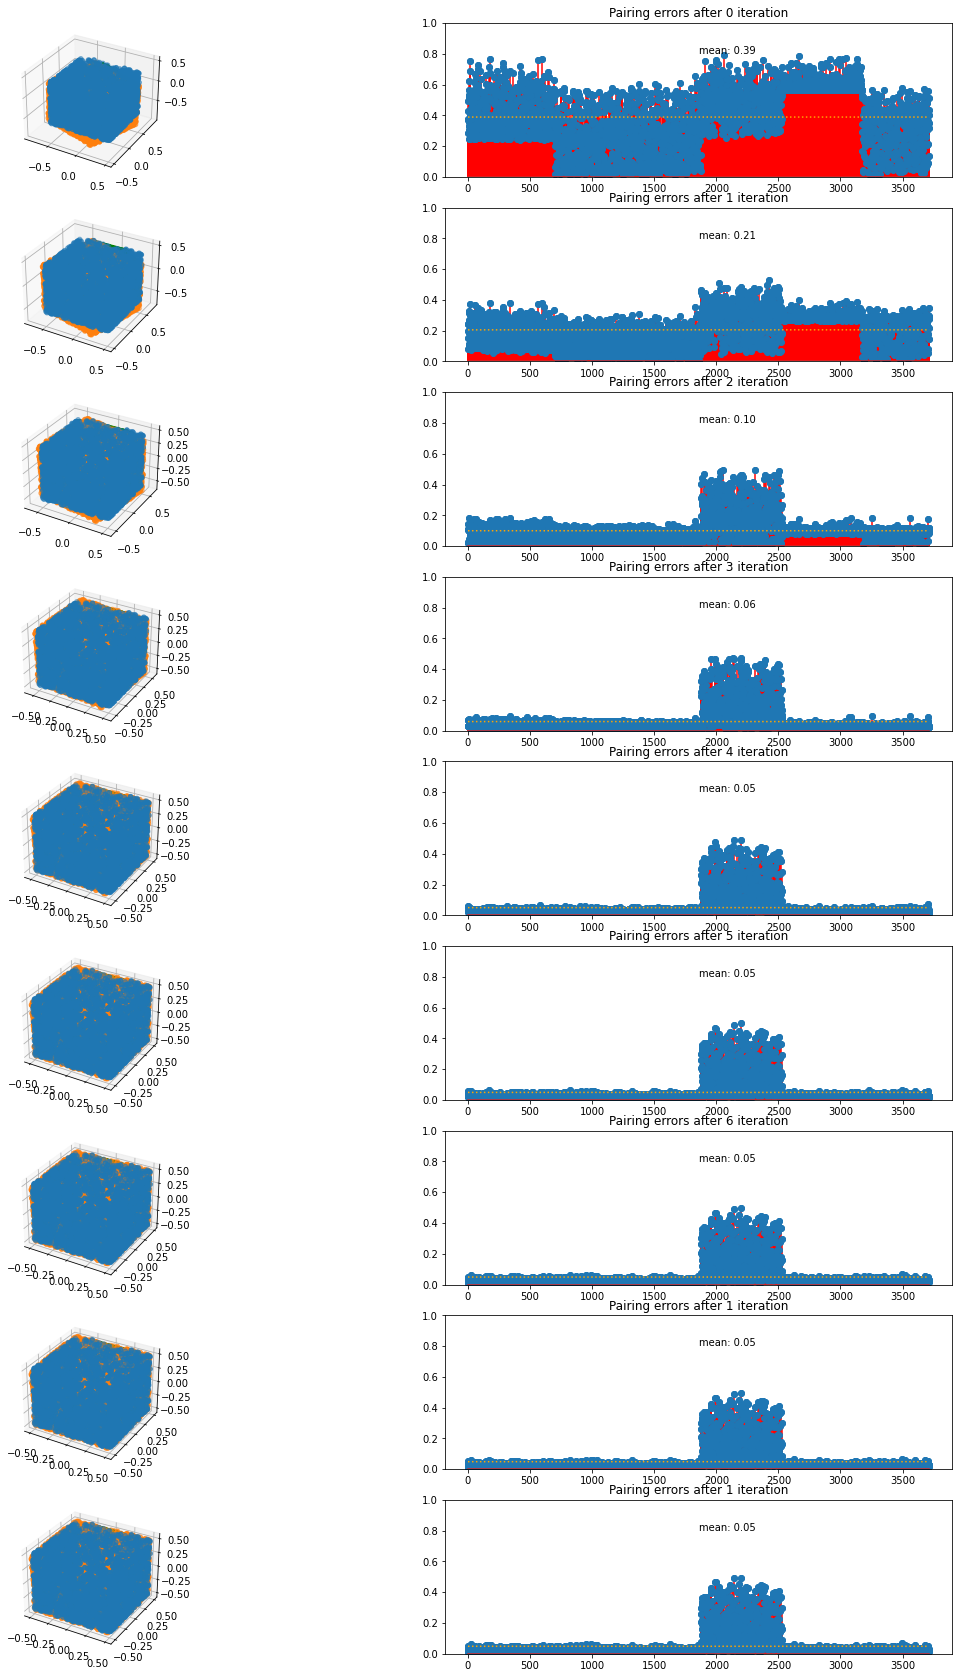

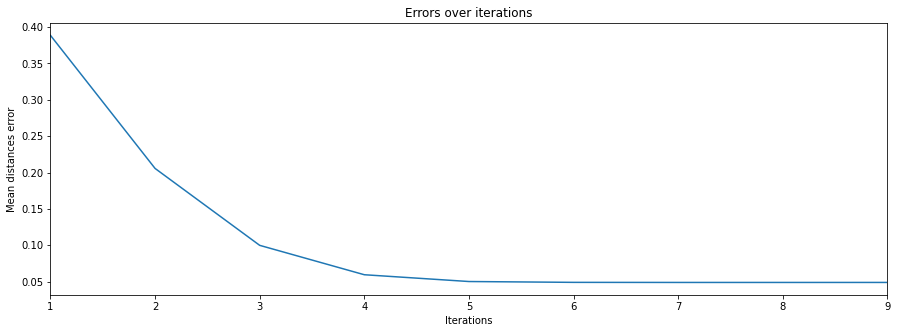

In [31]:
# C2: source
# C1: destination
# One face missing in the destination cube
plot_icp_progress(C2, C1)

**Comments**:
* As one face is missing in the destination cube, an error over that face in the source points is bigger (~0.06) than on the other faces (~0.1). The source points that are supposed to match on the missing destination face points try to match other destination faces which implies a bigger pairing distance. 
* However, visually the registration works well overall. 

### Several faces missing

In [32]:
C1 = generate_3d_cube(width=1, missing_faces=[(1, 1), (1, 0), (2, 1), (1, 0), (2, 0)]) # Front face missing
C2 = generate_3d_cube(width=1, missing_faces=[(2, 0)])
M_random_cube = randomTransformation3D(maxRot=25)
C2 = C2 @ M_random_cube.T
plot_cubes(C1, C2)

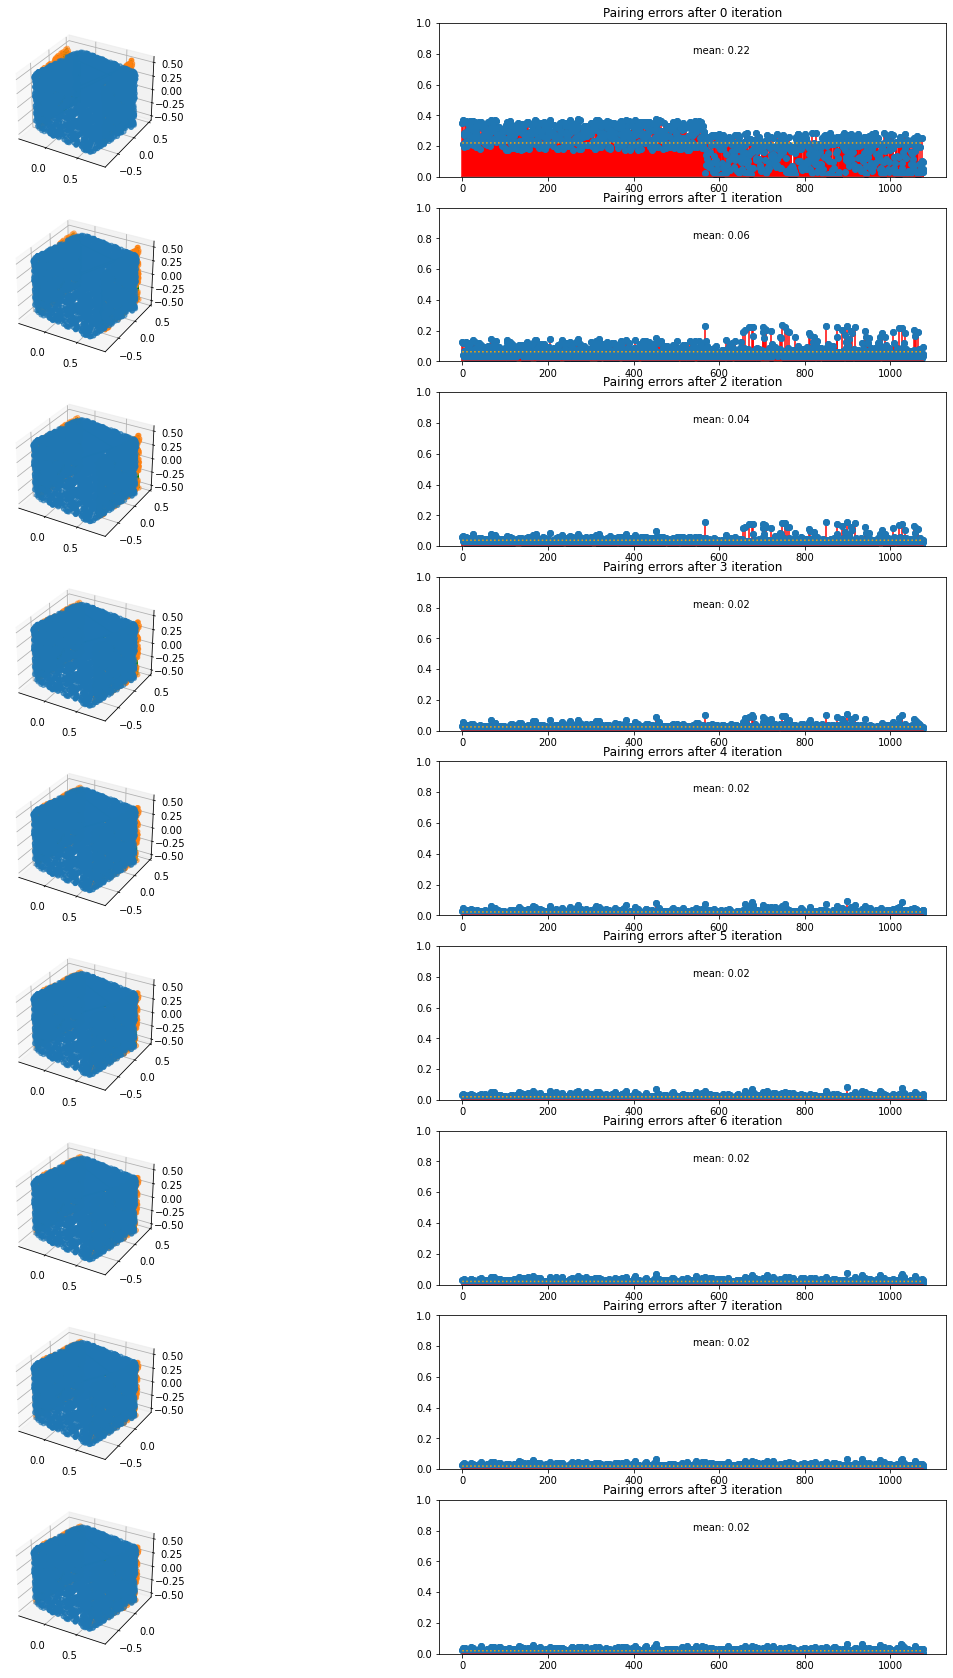

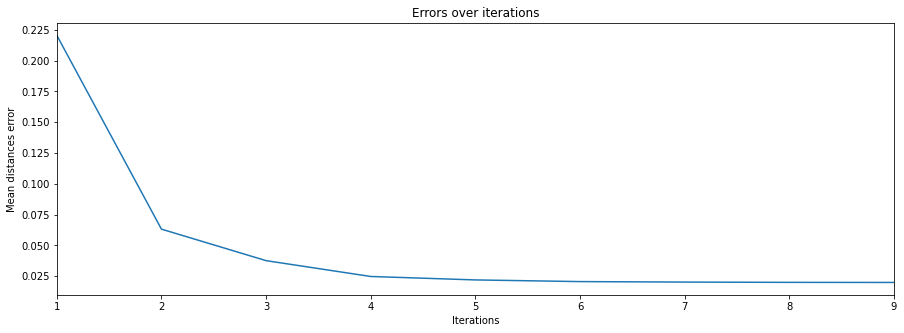

In [33]:
# C1: source
# C2: destination
# Several faces missing in the source
plot_icp_progress(C1, C2)

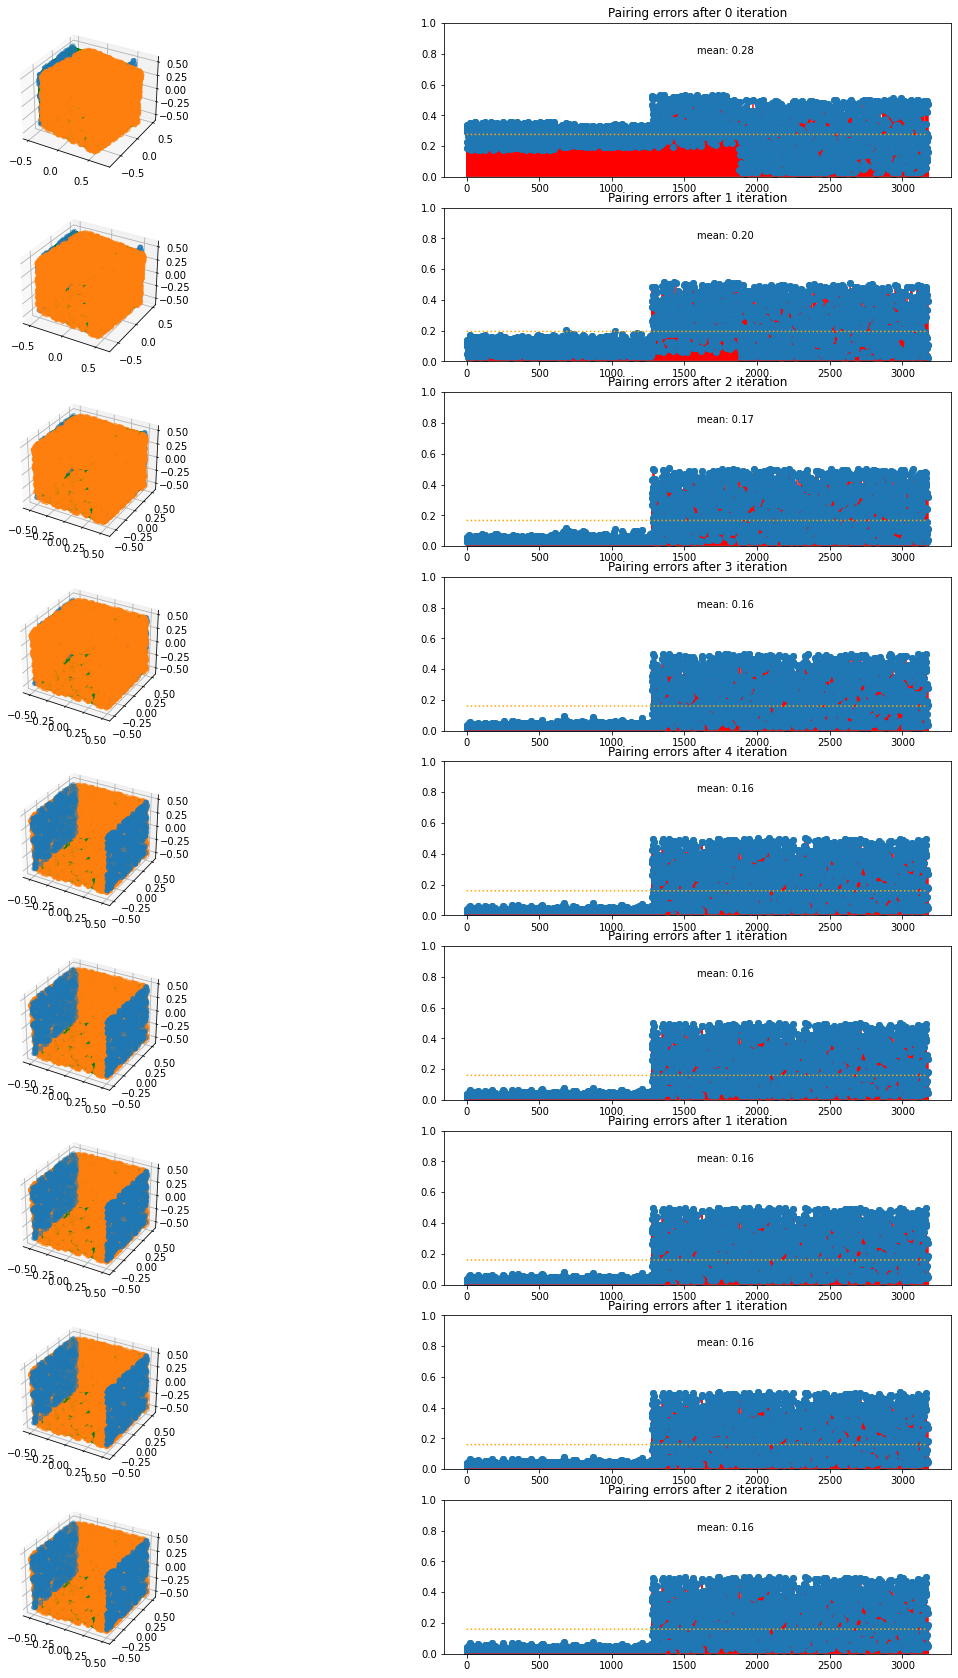

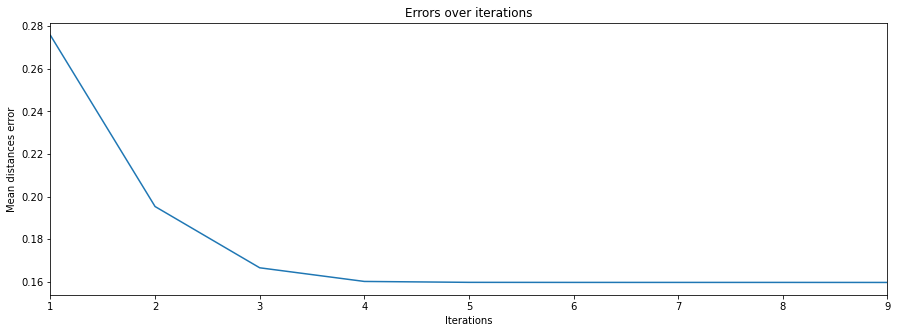

In [34]:
# C2: source
# C1: destination
# Several faces missing in the destination
plot_icp_progress(C2, C1)

**Conclusion**:
* If faces are missing in the source points, there is no issue as the source points will find easily the destinations points
* If faces are missing in the destination points, the source points from the missing faces will not be correctly paired.
* However, no matter whether the face is missing in the source cube or destination cube, it still works well visually.
* This is because of the shape of our data. As cubes are used, if one face of the cube is well registered then the whole cube is actually registred.
* To register a cube, at least one face from the source points must match one face from the destination points.